<h1 align=center><font size = 5>Explore Chinese Restaurants in New York City</font></h1>

## Introduction

The City of New York, usually called either **New York City (NYC)** or simply **New York (NY)**, is the most populous city in the United States.
New York City consists of five boroughs, each of which is a separate county of the State of New York. The five boroughs – Brooklyn, Queens, Manhattan, The Bronx, and Staten Island – were consolidated into a single city in 1898. The city and its metropolitan area constitute the premier gateway for legal immigration to the United States. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. New York City is home to more than 3.2 million residents born outside the United States, the largest foreign-born population of any city in the world.

New York City has the largest Chinese population of any city outside of Asia and within the U.S. with an estimated population of 573,388 in 2014  and continues to be a primary destination for new Chinese immigrants. New York City is subdivided into official municipal boroughs, which themselves are home to significant Chinese populations, with Brooklyn and Queens, adjacently located on Long Island, leading the fastest growth. After the City of New York itself, the boroughs of Queens and Brooklyn encompass the largest Chinese populations, respectively, of all municipalities in the United States.

So in this project , I will list and visualize all major parts of New York City that has great Chinese restaurants. People who want to run Chinese restaurant business should benefit from it.

## Data

The following data will be used in the analysis:

- New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
     - Data source: https://cocl.us/new_york_dataset
     - Description: This dataset contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.


- Chinese restaurants in each neighborhood of NYC.
     - Data source: Foursquare API
     - Description: Start utilizing the Foursquare API to explore the neighborhoods and get Chinese restaurants in each neighborhood.
 
 
- GeoSpace data
     - Data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
     - Description: By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.   
     

## Methodology

- Download and Explore Dataset https://cocl.us/new_york_dataset
- Using FourSquare API we will find all venues for each neighborhood.
- Filter out all venues that are Chinese Resturants.
- Find rating , tips and like count for each Chinese Resturants using FourSquare API.
- Using rating for each resturant , we will sort that data.
- Visualize the Ranking of neighborhoods using folium library(python)



## Coding

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries imported.')

Libraries imported.


## 1. Download and Explore Dataset https://cocl.us/new_york_dataset

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


Next, let's load the data.

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
#Notice how all the relevant data is in the features key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.
neighborhoods_data = newyork_data['features']

neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a pandas dataframe. So let's start by creating an empty dataframe.

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Then let's loop through the data and fill the dataframe one row at a time.

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [9]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [10]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [11]:
CLIENT_ID = 'VRX4PSRGXZGY5PK2X230MH1XVRS1MIATJE35D1XYKZT1AUFN' # your Foursquare ID
CLIENT_SECRET = 'LPE1AVUTUPR345XFH55YTF12VJBEYFSBIUCZPTI2BQ5YVXDU' # your Foursquare Secret
VERSION = '20180703' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VRX4PSRGXZGY5PK2X230MH1XVRS1MIATJE35D1XYKZT1AUFN
CLIENT_SECRET:LPE1AVUTUPR345XFH55YTF12VJBEYFSBIUCZPTI2BQ5YVXDU


We define a function to intract with FourSquare API and get top 50 venues within a radius of 100 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [12]:
LIMIT = 50 # limit of number of venues returned by Foursquare API
radius = 100 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue ID',          
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [13]:
NYC_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )


print(NYC_venues.shape)
NYC_venues.head()


Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,4c537892fd2ea593cb077a28,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,4d6af9426107f04dedeb297a,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,4c783cef3badb1f7e4244b54,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,508af256e4b0578944c87392,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,4c25c212f1272d7f836385c5,Dunkin',40.890459,-73.849089,Donut Shop


Let us filter on Chinese Restaurants.

In [19]:
NYC_Chinese_Rest=NYC_venues.loc[NYC_venues['Venue Category']=='Chinese Restaurant'].reset_index(drop=True)
NYC_Chinese_Rest.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Co-op City,40.874294,-73.829939,4c9d5f2654c8a1cd2e71834b,Guang Hui Chinese Restaurant,40.876603,-73.829710,Chinese Restaurant
1,Eastchester,40.887556,-73.827806,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant,40.888785,-73.831226,Chinese Restaurant
2,Norwood,40.877224,-73.879391,4e41d2c4b61ca5ba3b1f9c6b,Ming Liang Kitchen,40.879996,-73.876324,Chinese Restaurant
3,Pelham Parkway,40.857413,-73.854756,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,40.855790,-73.855455,Chinese Restaurant
4,Bedford Park,40.870185,-73.885512,4e2e08021838f1c552b6b8eb,Choi Yuan - Chinese Restaurant,40.873078,-73.889086,Chinese Restaurant


So we got data for all Chinese resturants. Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required.

In [20]:
NYC_Chinese_Rest.to_csv('NYC_Chinese_Rest.csv',index=False)

In [15]:
#left join neighborhoods to get 'Borough' field

NYC_Chinese_Rest_Data=pd.merge(NYC_Chinese_Rest, neighborhoods[['Borough', 'Neighborhood']],
                         on='Neighborhood',
                         how='left')

NYC_Chinese_Rest_Data.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Borough
0,Co-op City,40.874294,-73.829939,4c9d5f2654c8a1cd2e71834b,Guang Hui Chinese Restaurant,40.876603,-73.829710,Chinese Restaurant,Bronx
1,Eastchester,40.887556,-73.827806,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant,40.888785,-73.831226,Chinese Restaurant,Bronx
2,Norwood,40.877224,-73.879391,4e41d2c4b61ca5ba3b1f9c6b,Ming Liang Kitchen,40.879996,-73.876324,Chinese Restaurant,Bronx
3,Pelham Parkway,40.857413,-73.854756,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,40.855790,-73.855455,Chinese Restaurant,Bronx
4,Bedford Park,40.870185,-73.885512,4e2e08021838f1c552b6b8eb,Choi Yuan - Chinese Restaurant,40.873078,-73.889086,Chinese Restaurant,Bronx


In [16]:
NYC_Chinese_Rest_Data.to_csv('NYC_Chinese_Rest_Data.csv',index=False)

In [14]:
NYC_Chinese_Rest_Data=pd.read_csv('NYC_Chinese_Rest_Data.csv')

In [13]:
NYC_Chinese_Rest_Data.shape

(190, 9)

There are 190 Chinese Restaurants across New York City if we set LIMIT = 50 (limit of number of venues returned by Foursquare API) and radius = 100

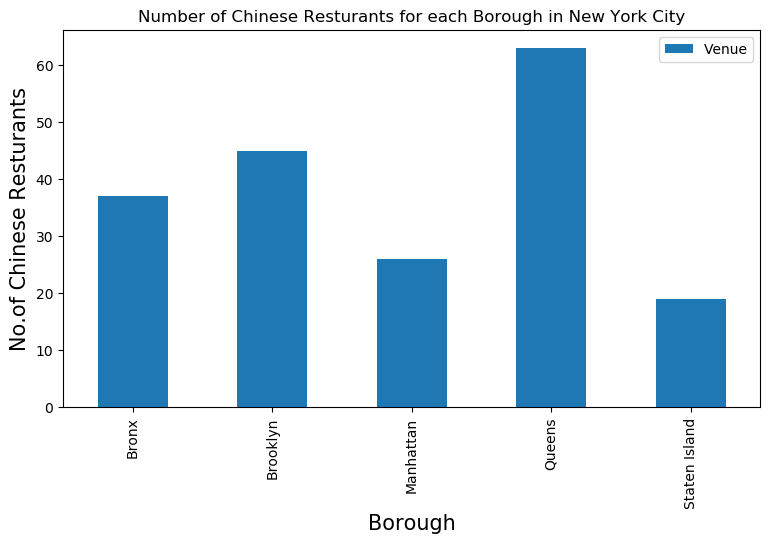

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
NYC_Chinese_Rest_Data.groupby('Borough')['Venue'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

From the plot, we can see that Queens has the largest number of Chinese restaurants.

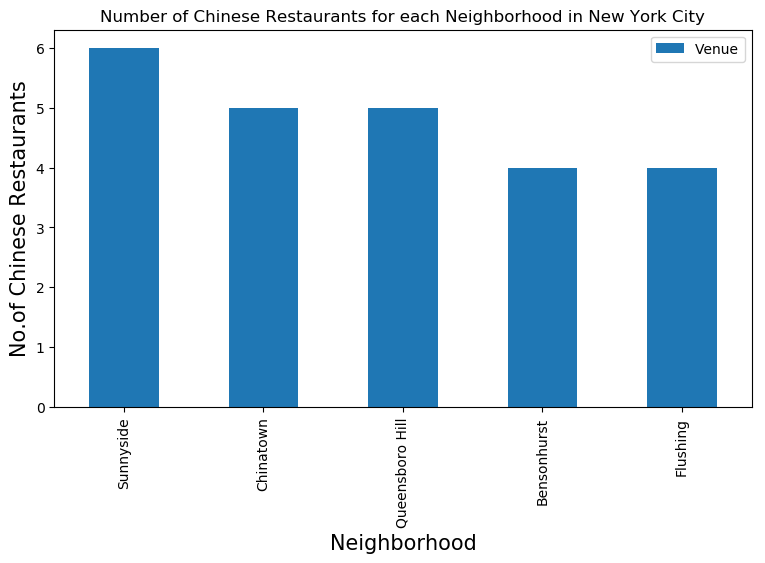

In [26]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Restaurants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Restaurants', fontsize=15)
#giving a bar plot
NYC_Chinese_Rest_Data.groupby('Neighborhood')['Venue'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

As the number of calls to get price for venue have limit of 50 per day, I have to break data by each Borough and make sure each data set contains less than 50 records.

In [15]:
NYC_Chinese_Rest_Data2=NYC_Chinese_Rest_Data[['Borough','Neighborhood','Venue','Venue ID']].rename(columns={"Venue ID":"ID"})
NYC_Chinese_Rest_Data2.head()

# Now break into different Borough: Manhattan
NYC_Chinese_Rest_Data_Manhattan=NYC_Chinese_Rest_Data2[NYC_Chinese_Rest_Data2['Borough']=='Manhattan'].reset_index(drop=True)

# Now break into different Borough: Queens
NYC_Chinese_Rest_Data_Queens=NYC_Chinese_Rest_Data2[NYC_Chinese_Rest_Data2['Borough']=='Queens'].reset_index(drop=True)

NYC_Chinese_Rest_Data_Queens_1=NYC_Chinese_Rest_Data_Queens.head(50).reset_index(drop=True)

NYC_Chinese_Rest_Data_Queens_2=NYC_Chinese_Rest_Data_Queens.tail(13).reset_index(drop=True)

# Now break into different Borough: Brooklyn
NYC_Chinese_Rest_Data_Brooklyn=NYC_Chinese_Rest_Data2[NYC_Chinese_Rest_Data2['Borough']=='Brooklyn'].reset_index(drop=True)

print(NYC_Chinese_Rest_Data_Manhattan.shape)
print(NYC_Chinese_Rest_Data_Queens.shape)
print(NYC_Chinese_Rest_Data_Queens_1.shape)
print(NYC_Chinese_Rest_Data_Queens_2.shape)
print(NYC_Chinese_Rest_Data_Brooklyn.shape)

(26, 4)
(63, 4)
(50, 4)
(13, 4)
(45, 4)


In [31]:
NYC_Chinese_Rest_Data_Manhattan

,Borough,Neighborhood,Venue,ID
0,Manhattan,Chinatown,Spicy Village,4db3374590a0843f295fb69b
1,Manhattan,Chinatown,Xi'an Famous Foods,5894c9a15e56b417cf79e553
2,Manhattan,Chinatown,Wah Fung Number 1 Fast Food 華豐快飯店,4a96bf8ff964a520ce2620e3
3,Manhattan,Chinatown,Great N.Y. Noodletown,3fd66200f964a520b1ea1ee3
4,Manhattan,Chinatown,Joe's Shanghai 鹿嗚春,3fd66200f964a52067e61ee3
5,Manhattan,Washington Heights,Yang Garden,4b292f38f964a520939a24e3
6,Manhattan,Inwood,Lotus Express,4b9aeeedf964a52086e435e3
7,Manhattan,Inwood,"""U"" Like",4bd5f4d229eb9c74c64594e1
8,Manhattan,Hamilton Heights,King's Wok,4cd76fd7dfb4a1cd7195645c
9,Manhattan,Manhattanville,China Place,4b21974df964a520833e24e3


In [3]:
def get_url(Venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            Venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    results = requests.get(url).json()['response']['venue']
    return(results)

In [10]:
Test = get_url(Venue_id='4c87c9930dcb8cfa68e63d68')
Test

KeyError: 'venue'

First, let us define a function to get venue details like count , price , tip counts for a given venue id. This will be used for getting price.

Now we will get the price of each resturant for further analysis.

1.Manhattan

In [22]:
# get likes, price, tips
#Manhattan
def get_venue_details(venue_id):
        
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_price=venue_data['price']['message']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_price,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Venue','Likes','Price','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

# prepare neighborhood list that contains Chinese restaurants
column_names=['Borough', 'Neighborhood','ID','Venue','Likes','Price','Tips']
NYC_Chinese_Rest_Manhattan_price=pd.DataFrame(columns=column_names)
count=1


for row in NYC_Chinese_Rest_Data_Manhattan.values.tolist():
    Borough,Neighborhood,Venue,ID=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,price,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,price,tips=[0]*5
    print('(',count,'/',len(NYC_Chinese_Rest_Data_Manhattan),')','processed')
    NYC_Chinese_Rest_Manhattan_price = NYC_Chinese_Rest_Manhattan_price.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Venue' : name,
                                                'Likes' : likes,
                                                'Price' : price,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID          Venue  Likes  Price  Tips
0  4db3374590a0843f295fb69b  Spicy Village    489  Cheap   181
( 1 / 26 ) processed
                         ID               Venue  Likes  Price  Tips
0  5894c9a15e56b417cf79e553  Xi'an Famous Foods     92  Cheap    26
( 2 / 26 ) processed
                         ID                              Venue  Likes  Price  \
0  4a96bf8ff964a520ce2620e3  Wah Fung Number 1 Fast Food 華豐快飯店    179  Cheap   

   Tips  
0    91  
( 3 / 26 ) processed
                         ID                  Venue  Likes  Price  Tips
0  3fd66200f964a520b1ea1ee3  Great N.Y. Noodletown    529  Cheap   285
( 4 / 26 ) processed
                         ID               Venue  Likes     Price  Tips
0  3fd66200f964a52067e61ee3  Joe's Shanghai 鹿嗚春   1283  Moderate   568
( 5 / 26 ) processed
                         ID        Venue  Likes     Price  Tips
0  4b292f38f964a520939a24e3  Yang Garden      6  Moderate     2
( 6 / 26 ) processed
                   

In [24]:
NYC_Chinese_Rest_Manhattan_price.to_csv('NYC_Chinese_Rest_Manhattan_price.csv',index=False)

In [32]:
NYC_Chinese_Rest_Manhattan_price.head()

,Borough,Neighborhood,ID,Venue,Likes,Price,Tips
0,Manhattan,Chinatown,4db3374590a0843f295fb69b,Spicy Village,489,Cheap,181
1,Manhattan,Chinatown,5894c9a15e56b417cf79e553,Xi'an Famous Foods,92,Cheap,26
2,Manhattan,Chinatown,4a96bf8ff964a520ce2620e3,Wah Fung Number 1 Fast Food 華豐快飯店,179,Cheap,91
3,Manhattan,Chinatown,3fd66200f964a520b1ea1ee3,Great N.Y. Noodletown,529,Cheap,285
4,Manhattan,Chinatown,3fd66200f964a52067e61ee3,Joe's Shanghai 鹿嗚春,1283,Moderate,568


2.Queens

In [16]:
# get likes, price, tips
#Queens
def get_venue_details(venue_id):
        
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_price=venue_data['price']['message']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_price,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Venue','Likes','Price','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

# prepare neighborhood list that contains Chinese restaurants
column_names=['Borough', 'Neighborhood','ID','Venue','Likes','Price','Tips']
NYC_Chinese_Rest_Queens_price=pd.DataFrame(columns=column_names)
count=1


for row in NYC_Chinese_Rest_Data_Queens_1.values.tolist():
    Borough,Neighborhood,Venue,ID=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,price,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,price,tips=[0]*5
    print('(',count,'/',len(NYC_Chinese_Rest_Data_Queens_1),')','processed')
    NYC_Chinese_Rest_Queens_price = NYC_Chinese_Rest_Queens_price.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Venue' : name,
                                                'Likes' : likes,
                                                'Price' : price,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID      Venue  Likes  Price  Tips
0  5bd497a9f427de003989e9d8  Dun Huang     15  Cheap     0
( 1 / 50 ) processed
                         ID       Venue  Likes     Price  Tips
0  4e3484038877beb5e9a22a0b  Café China   1010  Moderate   274
( 2 / 50 ) processed
                         ID               Venue  Likes  Price  Tips
0  4ae1d8b2f964a520e78721e3  Peking BBQ Chicken     47  Cheap    24
( 3 / 50 ) processed
                         ID                       Venue  Likes  Price  Tips
0  56296f14498edb1ed77b64a3  Five Loaves and Two Fishes     10  Cheap     1
( 4 / 50 ) processed
                         ID         Venue  Likes  Price  Tips
0  4eaf0752d3e30d448393b841  Lao Bei Fang     79  Cheap    49
( 5 / 50 ) processed
                         ID                   Venue  Likes  Price  Tips
0  4b944c64f964a520907334e3  Sweet Yummy House 三好小馆     17  Cheap     6
( 6 / 50 ) processed
                         ID          Venue  Likes  Price  Tips
0  4ba57b0a

2.1 Queens data file 1

2.1 Queens data file 2

In [20]:

# prepare neighborhood list that contains Chinese restaurants
column_names=['Borough', 'Neighborhood','ID','Venue','Likes','Price','Tips']
NYC_Chinese_Rest_Queens_price=pd.DataFrame(columns=column_names)
count=1


for row in NYC_Chinese_Rest_Data_Queens_2.values.tolist():
    Borough,Neighborhood,Venue,ID=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,price,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,price,tips=[0]*5
    print('(',count,'/',len(NYC_Chinese_Rest_Data_Queens_2),')','processed')
    NYC_Chinese_Rest_Queens_price = NYC_Chinese_Rest_Queens_price.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Venue' : name,
                                                'Likes' : likes,
                                                'Price' : price,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID      Venue  Likes  Price  Tips
0  4d69549ede28224b0ac241be  Xing Xing      2  Cheap     3
( 1 / 13 ) processed


KeyError: 'venue'

In [18]:
NYC_Chinese_Rest_Queens_price.to_csv('NYC_Chinese_Rest_Queens_price_1.csv',index=False)

In [19]:
NYC_Chinese_Rest_Queens_price.head()

,Borough,Neighborhood,ID,Venue,Likes,Price,Tips
0,Queens,Murray Hill,5bd497a9f427de003989e9d8,Dun Huang,15,Cheap,0
1,Queens,Murray Hill,4e3484038877beb5e9a22a0b,Café China,1010,Moderate,274
2,Queens,Woodside,4ae1d8b2f964a520e78721e3,Peking BBQ Chicken,47,Cheap,24
3,Queens,Elmhurst,56296f14498edb1ed77b64a3,Five Loaves and Two Fishes,10,Cheap,1
4,Queens,Elmhurst,4eaf0752d3e30d448393b841,Lao Bei Fang,79,Cheap,49
